In [25]:
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pylab as plt

%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs  
from numpy import log

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

In [26]:
#To import the dataset
rice_inventory=pd.read_csv("NFA_RICE_PH_data.csv", names = ['Date', 'Rice_Stock'], header = 0)
#Parse strings to datetime type
rice_inventory['Date']=pd.to_datetime(rice_inventory['Date'],infer_datetime_format=True)
RiceInventory=rice_inventory.set_index(['Date']) #Date is now the index

In [27]:
#Display first few data
from datetime import datetime
RiceInventory.head(5)

,Rice_Stock
Date,
2007-01-01,455.2
2007-02-01,356.7
2007-03-01,274.1
2007-04-01,177.3
2007-05-01,256.2


In [28]:
#Partition the data into the Test and Training Set 
#80% for the training set and 20% for the test set
n=len(RiceInventory)
n
start_index=n-round(0.20*n)  
start_index

trainingset=RiceInventory.iloc[:start_index] #12 years from 2008-2019
testset=RiceInventory.iloc[start_index:] #3 years for 2020-2022
trainingset.tail()

trainingset.index = pd.DatetimeIndex(trainingset.index.values,freq=trainingset.index.inferred_freq)

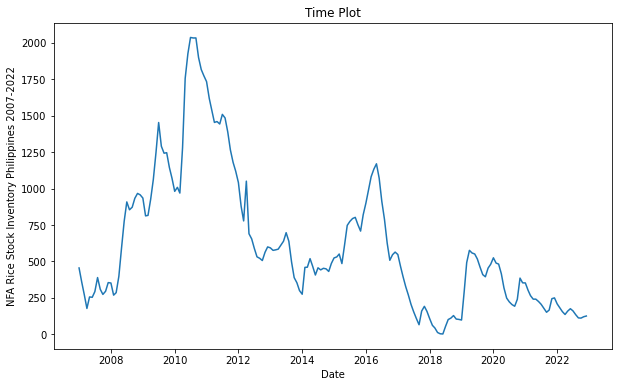

In [29]:
#Time Plot
#Plot the data for preliminary analysis
plt.xlabel("Date")
plt.ylabel("NFA Rice Stock Inventory Philippines 2007-2022")
plt.title("Time Plot")
plt.plot(RiceInventory)
plt.show()

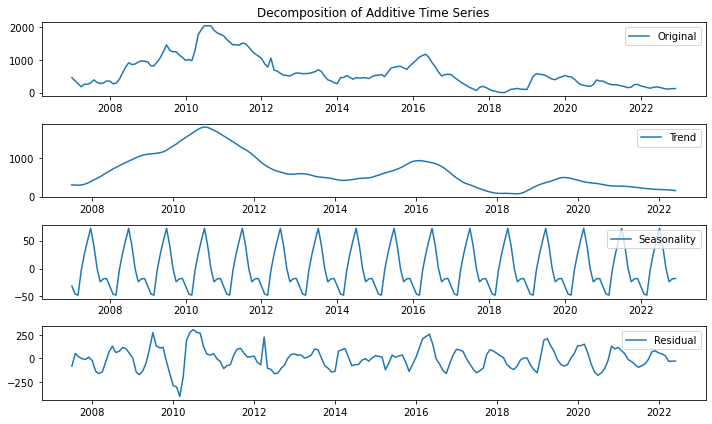

In [30]:
#Decompose the Time Plot
#Time Series Decomposition; Additive
decomposition=seasonal_decompose(RiceInventory["Rice_Stock"],model="add")

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.title("Decomposition of Additive Time Series")
plt.plot(RiceInventory,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

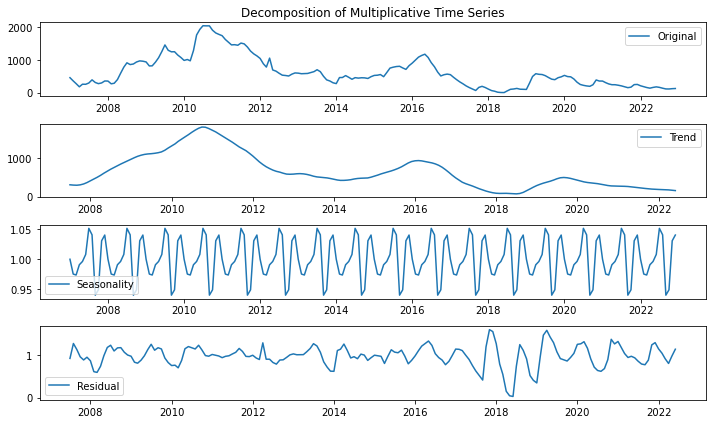

In [31]:
#Decompose the Time Plot
#Time Series Decomposition; Multiplicative
decomposition=seasonal_decompose(RiceInventory["Rice_Stock"],model="multiply")

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.title("Decomposition of Multiplicative Time Series")
plt.plot(RiceInventory,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

# Check for Stationarity

In [32]:
res = adfuller(rice_inventory.Rice_Stock.dropna())  
print('Augmented Dickey-Fuller Statistic: %f' % res[0])  
print('p-value: %f' % res[1])  

Augmented Dickey-Fuller Statistic: -1.965357
p-value: 0.301966


The p-value is greater than a significance level of 0.05, hence the time series is non-stationary.

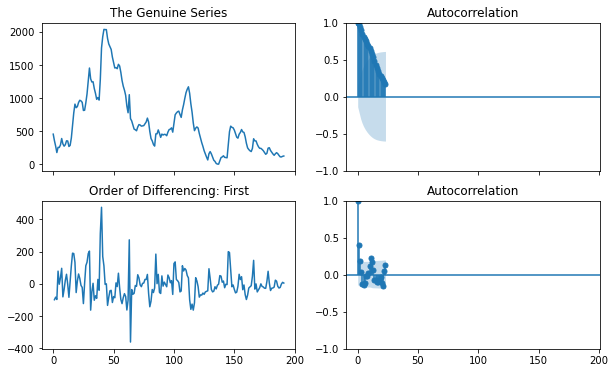

In [33]:
# The Genuine Series  
fig, axes = plt.subplots(2, 2, sharex = True)  
axes[0, 0].plot(rice_inventory.Rice_Stock); axes[0, 0].set_title('The Genuine Series')  
plot_acf(rice_inventory.Rice_Stock, ax = axes[0, 1])  

# Order of Differencing: First  
axes[1, 0].plot(rice_inventory.Rice_Stock.diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(rice_inventory.Rice_Stock.diff().dropna(), ax = axes[1, 1])  
  
plt.show()  

In [34]:
X = rice_inventory.Rice_Stock
  
# Augmented Dickey Fuller Test  
adftest = ndiffs(X, test = 'adf')  
  
# KPSS Test  
kpsstest = ndiffs(X, test = 'kpss')  
  
# PP Test  
pptest = ndiffs(X, test = 'pp')  
  
print("ADF Test =", adftest)  
print("KPSS Test =", kpsstest)  
print("PP Test =", pptest)  

ADF Test = 1
KPSS Test = 1
PP Test = 1


# Creating the Model

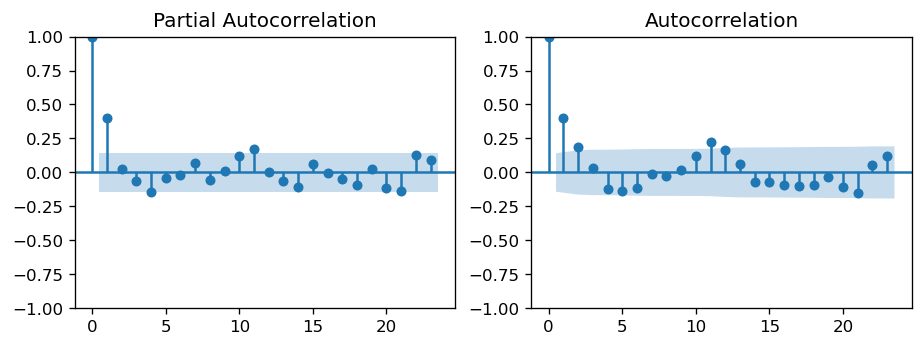

In [35]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) 
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].set(ylim = (0,5))
plot_pacf(rice_inventory.Rice_Stock.diff().dropna(), ax = axes[0], method = 'ywm')
axes[1].set(ylim = (0, 1.2))
plot_acf(rice_inventory.Rice_Stock.diff().dropna(), ax = axes[1])
plt.show()

The PACF plot show that lag 1, 2, and 12 are above the line of significance. While the ACF plot shows that lag 1 is significantly above the line of significance.

# Building the ARIMA Model

In [36]:
model1 = ARIMA(trainingset, order=(1,1,1))
model_fit = model1.fit()
print(model_fit.summary())

forecast_test1 = model_fit.forecast(len(testset))
RiceInventory['forecast_auto'] = [None]*len(trainingset) + list(forecast_test1)

RiceInventory.plot

                               SARIMAX Results                                
Dep. Variable:             Rice_Stock   No. Observations:                  154
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -906.042
Date:                Thu, 19 Jan 2023   AIC                           1818.084
Time:                        15:31:43   BIC                           1827.175
Sample:                    01-01-2007   HQIC                          1821.777
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4570      0.181      2.520      0.012       0.102       0.812
ma.L1         -0.0648      0.173     -0.374      0.709      -0.405       0.275
sigma2      8138.6891    481.766     16.893      0.0

In [37]:
#Calculate Errors for the ARIMA(0,1,1)
MAE = mean_absolute_error(testset, forecast_test1)
MAPE = mean_absolute_percentage_error(testset, forecast_test1)
RMSE = np.sqrt(mean_squared_error(testset, forecast_test1))

print(f'MAE - manual: {MAE}')
print(f'MAPE - manual: {MAPE}')
print(f'RMSE - manual: {RMSE}')

MAE - manual: 157.68717255662193
MAPE - manual: 0.8855728850854294
RMSE - manual: 173.60539391792145


In [38]:
#Using Auto ARIMA function to get a model.
auto_arima = pm.auto_arima(trainingset, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [39]:
model = ARIMA(trainingset, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

forecast_test2 = model_fit.forecast(len(testset))
RiceInventory['forecast_auto'] = [None]*len(trainingset) + list(forecast_test1)

RiceInventory.plot

                               SARIMAX Results                                
Dep. Variable:             Rice_Stock   No. Observations:                  154
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -906.112
Date:                Thu, 19 Jan 2023   AIC                           1816.224
Time:                        15:31:48   BIC                           1822.285
Sample:                    01-01-2007   HQIC                          1818.686
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4025      0.045      8.997      0.000       0.315       0.490
sigma2      8146.5423    483.504     16.849      0.000    7198.891    9094.193
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [40]:
#Calculate Errors for the ARIMA(1,1,0)
MAE = mean_absolute_error(testset, forecast_test2)
MAPE = mean_absolute_percentage_error(testset, forecast_test2)
RMSE = np.sqrt(mean_squared_error(testset, forecast_test2))

print(f'MAE - manual: {MAE}')
print(f'MAPE - manual: {MAPE}')
print(f'RMSE - manual: {RMSE}')

MAE - manual: 159.88969654381899
MAPE - manual: 0.8989716714315359
RMSE - manual: 176.12732286437526


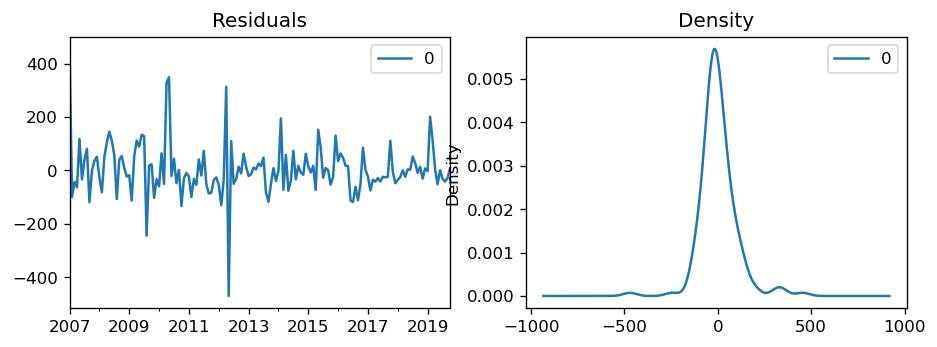

In [41]:
#Plotting Residuals
modelfit = model.fit() 
residuals = pd.DataFrame(modelfit.resid)  
fig, ax = plt.subplots(1,2)  
residuals.plot(title = "Residuals", ax = ax[0])  
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])  
plt.show()  

The residual errors look fair with around zero mean and uniform variance

# Building and Evaluating the Forecast

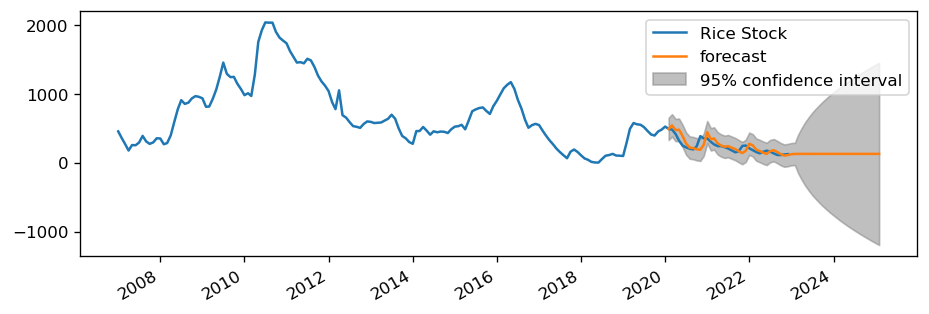

In [57]:
data = rice_inventory.copy()
data['Date']=pd.to_datetime(rice_inventory['Date'],infer_datetime_format=True)
RiceInv=data.set_index(['Date'])

data.index = pd.date_range(start='2007-01', end='2023-01', freq='M')
res = ARIMA(data.Rice_Stock, order=(1,1,0)).fit()
fig, ax = plt.subplots()
plt.plot(RiceInventory.Rice_Stock, label = "Rice Stock")
plot_predict(res, start='2020-01', end='2025-01', ax=ax)  
plt.show()

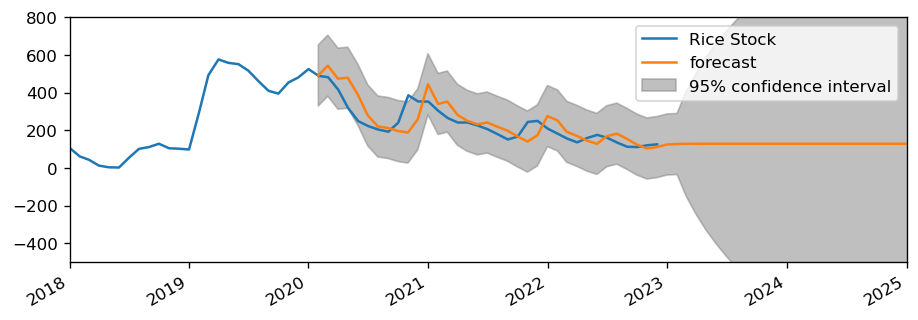

In [58]:
#A cLose up on the forecast.
fig, ax = plt.subplots()
plt.plot(RiceInventory.Rice_Stock, label = "Rice Stock")
plot_predict(res, start='2020-01', end='2025-01', ax=ax)
plt.axis(['2018-01', '2025-01', -500, 800])
plt.show()